# **Intro**

In this notebook we perform preliminary data exploration, preprocessing, and feature selection for the Kaggle House Prices - Advanced Regression Techniques Competition. This is a regression task where the aim is to predict the sale price of a house using several numerical and categorical features of each house. 

Team: ML_Masters (Raveena Kshatriya, Philip Osborne, & Pithayuth Charnsethikul)



**References**


*   https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
*   https://machinelearningmastery.com/rfe-feature-selection-in-python/
*   https://medium.com/@aneesha/recursive-feature-elimination-with-scikit-learn-3a2cbdf23fb7
*   https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
*   https://www.kaggle.com/ekami66/detailed-exploratory-data-analysis-with-python
*   https://towardsdatascience.com/introduction-to-data-preprocessing-in-machine-learning-a9fa83a5dc9d

## **Load Data**

---



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,LabelEncoder,OneHotEncoder
from sklearn.feature_selection import chi2,f_regression,RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_validate
import warnings
import pickle
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Load Training Data
train = pd.read_csv('/content/gdrive/MyDrive/csci567_house-prices-advanced-regression-techniques/train.csv').drop(columns='Id')
target = train['SalePrice']

print('Number of samples: {}'.format(len(train.index)))
print('Number of features: {}'.format(len(train.columns)-1))
train.head()

Number of samples: 1460
Number of features: 79


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We have a mix of continuous, ordinal, and categorical variables with a continuous target variable. 

**Examine the target variable (SalePrice)**

In [ ]:
#Check for any missing values
target.isnull().any()

False

In [ ]:
# Statistics of the target variable
target.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

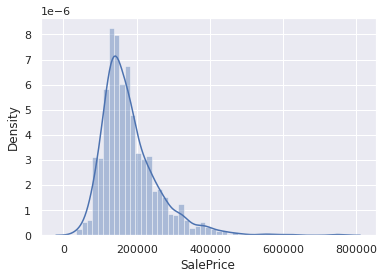

In [ ]:
# Histogram to check for outliers
sns.distplot(target)

Target seems to follow a skewed right distribution with mean=18,0921 and std=7,9443

We can see that the density of samples gets sparser as the sale price increases. However after examining the training data we don't believe the highest sale price samples are outliers that are worth removing from the dataset. Therefore we proceed with the entire dataset. 

In [ ]:
#List feature types
list(set(train.dtypes.tolist()))

[dtype('O'), dtype('int64'), dtype('float64')]

# **Handle Missing Data**


---





In [ ]:
#Fill the values that shouldn't be interpreted as NA
train['Alley'] = train['Alley'].fillna('None')
train['MiscFeature'] = train['MiscFeature'].fillna('None')
train['Fence'] = train['Fence'].fillna('None')
train['MasVnrType'] = train['MasVnrType'].fillna('None')
train['GarageType'] = train['GarageType'].fillna('None')
train['LotFrontage'] = train['LotFrontage'].fillna(0)
train['MasVnrArea'] = train['MasVnrArea'].fillna(0)

In [ ]:
#Map the string ordinal features
lot_shape_mapping = {"IR3": 4, "IR2": 3, "IR1": 2, "Reg":1}
utilities_mapping = {"ELO": 1, "NoSeWa": 2, "NoSewr": 3, "AllPub":4}
land_slope_mapping = {"Sev": 3, "Mod": 2, "Gtl": 1}
exter_mapping = {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
bsmt_mapping = {"NA": 1, "Po": 2, "Fa": 3, "TA": 4, "Gd": 5, "Ex": 6}
bsmt_exposure_mapping = {"NA": 1, "No": 2, "Mn": 3, "Av":4, "Gd": 5}
bsmt_fin_mapping = {"NA": 1, "Unf": 2, "LwQ": 3, "Rec":4, "BlQ": 5, "AlQ": 6, "GlQ": 7}
functional_mapping = {"Sal": 1, "Sev": 2, "Maj2": 3, "Maj1":4, "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}
garage_finish_mapping = {"NA": 1, "Unf": 2, "RFn": 3, "Fin":4}
pool_mapping = {'NA': 1, 'FA': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
paved_mapping = {'N':0, 'P': 1, 'Y': 2}
train['LotShape'] = train['LotShape'].map(lot_shape_mapping).astype(int)
train['Utilities'] = train['Utilities'].map(utilities_mapping).astype(int)
train['LandSlope'] = train['LandSlope'].map(land_slope_mapping).astype(int)
train["ExterQual"] = train["ExterQual"].map(exter_mapping).astype(int)
train["ExterCond"] = train["ExterCond"].map(exter_mapping).astype(int)
train["BsmtQual"] = train["BsmtQual"].map(bsmt_mapping).fillna(1).astype(int)
train["BsmtCond"] = train["BsmtCond"].map(bsmt_mapping).fillna(1).astype(int)
train['BsmtExposure'] = train['BsmtExposure'].map(bsmt_exposure_mapping).fillna(1).astype(int)
train['BsmtFinType1'] = train['BsmtFinType1'].map(bsmt_fin_mapping).fillna(1).astype(int)
train['BsmtFinType2'] = train['BsmtFinType2'].map(bsmt_fin_mapping).fillna(1).astype(int)
train["HeatingQC"] = train["HeatingQC"].map(exter_mapping).astype(int)
train["KitchenQual"] = train["KitchenQual"].map(exter_mapping).astype(int)
train['Functional'] = train['Functional'].map(functional_mapping).astype(int)
train["FireplaceQu"] = train["FireplaceQu"].map(bsmt_mapping).fillna(1).astype(int)
train['GarageFinish'] = train['GarageFinish'].map(garage_finish_mapping).fillna(1).astype(int)
train["GarageQual"] = train["GarageQual"].map(bsmt_mapping).fillna(1).astype(int)
train["GarageCond"] = train["GarageCond"].map(bsmt_mapping).fillna(1).astype(int)
train['PoolQC'] = train['PoolQC'].map(pool_mapping).fillna(1).astype(int)
train['PavedDrive'] = train['PavedDrive'].map(paved_mapping).astype(int)


In [ ]:
#Compute the percerntage of missing values for each feature
total_missing = train.isnull().sum().sort_values(ascending=False)
percent_missing = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
df_missing = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
df_missing.head()

,Total,Percent
GarageYrBlt,81,0.055479
Electrical,1,0.000685
SalePrice,0,0.000000
Foundation,0,0.000000
RoofMatl,0,0.000000


In [ ]:
#Fill Missing Data
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(int(train['GarageYrBlt'].mean()))
train['Electrical'] = train['Electrical'].fillna('Unknown') 

We fill the missing GarageYrBuilt values with the mean of the feature, as this will allow us to still use the samples with a missing value. We use the mean of the feature because we know that this is the value that is equidistant from the rest of the values in the feature. This means that this point won't have a large effect on how the feature is interpreted by the model. 

#**Feature Engineering/Exploration**

---



In [ ]:
train['TotalSF'] = train[['1stFlrSF','2ndFlrSF','BsmtFinSF1','BsmtFinSF2']].sum(axis=1)
train['TotalBath'] = train['BsmtFullBath']+train['FullBath']+0.5*(train['HalfBath']+train['BsmtHalfBath'])
train['TotalPorchSF'] = train[['OpenPorchSF','3SsnPorch','EnclosedPorch','ScreenPorch','WoodDeckSF']].sum(axis=1)

In [ ]:
#Combine related features
train['ExterQualCond'] = train['ExterQual']+train['ExterCond']
train['GrgQualCond'] = train['GarageQual']+train['GarageCond']
train['BsmtQualCond'] = train['BsmtQual']+train['BsmtCond']+train['BsmtFinType1']+train['BsmtFinType2']
train['OverallQualCond'] = train['OverallQual']+train['OverallCond']
train['TotalQual'] = train['ExterQualCond']+train['GrgQualCond']+train['BsmtQualCond']+train['OverallQual']+train['HeatingQC']+train['KitchenQual']

train.drop(columns=['ExterQual','BsmtQual','GarageQual','HeatingQC','Utilities'],inplace=True)


In [ ]:
#add some indicator features
train['HasGarage'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train['HasBsmt'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPool'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train['HasFireplace'] = train['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
train['HasPorch'] = train['TotalPorchSF'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
ordinal_features = ['OverallQual','OverallCond','LotShape','LandSlope','ExterQualCond','ExterCond','BsmtQualCond','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','KitchenQual','Functional','FireplaceQu','GarageFinish','GrgQualCond','GarageCond','PoolQC','PavedDrive']

**Examine the numerical features**

In [ ]:
#exclude some features from numerical
train['MSSubClass'] = train['MSSubClass'].astype(object)


In [ ]:
#Grab all numerical features
train_num = train.select_dtypes(include=[ 'int64','float64']).drop(columns='SalePrice')
print('Number of numerical features: {}'.format(len(train_num.columns)))
train_num.head()

Number of numerical features: 62


,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,TotalSF,TotalBath,TotalPorchSF,ExterQualCond,GrgQualCond,BsmtQualCond,OverallQualCond,TotalQual,HasGarage,HasBsmt,HasPool,HasFireplace,HasPorch
0,65.0,8450,1,1,7,5,2003,2003,196.0,3,4,2,1,706,2,0,150,856,856,854,0,1710,1,0,2,1,3,1,4,8,8,0,1,2003.0,3,2,548,4,2,0,61,0,0,0,0,1,0,2,2008,2416,3.5,61,7,8,12,12,43,1,1,0,0,1
1,80.0,9600,1,1,6,8,1976,1976,0.0,3,4,5,1,978,2,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,3,6,8,1,4,1976.0,3,2,460,4,2,298,0,0,0,0,0,1,0,5,2007,2240,2.5,298,6,8,12,14,40,1,1,0,1,1
2,68.0,11250,2,1,7,5,2001,2002,162.0,3,4,3,1,486,2,0,434,920,920,866,0,1786,1,0,2,1,3,1,4,6,8,1,4,2001.0,3,2,608,4,2,0,42,0,0,0,0,1,0,9,2008,2272,3.5,42,7,8,12,12,43,1,1,0,1,1
3,60.0,9550,2,1,7,5,1915,1970,0.0,3,5,2,1,216,2,0,540,756,961,756,0,1717,1,0,1,0,3,1,4,7,8,1,5,1998.0,2,3,642,4,2,0,35,272,0,0,0,1,0,2,2006,1933,2.0,307,6,8,12,12,41,1,1,0,1,1
4,84.0,14260,2,1,8,5,2000,2000,350.0,3,4,4,1,655,2,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,4,9,8,1,4,2000.0,3,3,836,4,2,192,84,0,0,0,0,1,0,12,2008,2853,3.5,276,7,8,12,13,44,1,1,0,1,1


In [ ]:
#Statistics of the numerical features
train_num.describe()

,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,TotalSF,TotalBath,TotalPorchSF,ExterQualCond,GrgQualCond,BsmtQualCond,OverallQualCond,TotalQual,HasGarage,HasBsmt,HasPool,HasFireplace,HasPorch
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,57.623288,10516.828082,1.408219,1.062329,6.099315,5.575342,1971.267808,1984.865753,103.117123,3.083562,3.934932,2.630137,1.669178,443.639726,2.034247,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,3.511644,6.517808,7.841781,0.613014,2.825342,1978.478082,2.715753,1.767123,472.980137,3.808904,1.856164,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,1.011644,43.489041,6.321918,2007.815753,1999.808219,2.210616,181.329452,6.479452,7.619178,12.127397,11.674658,39.982192,0.944521,0.974658,0.004795,0.527397,0.826027
std,34.664304,9981.264932,0.582296,0.276232,1.382997,1.112799,30.202904,20.645407,180.731373,0.351054,0.552159,1.067391,0.932695,456.098091,0.499683,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,0.663760,1.625393,0.667698,0.644666,1.810877,23.994863,0.892831,0.747315,213.804841,0.719685,0.496592,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,0.200756,496.123024,2.703626,1.328095,773.992942,0.785399,156.656097,0.675825,1.427782,1.677228,1.693527,4.485720,0.228992,0.157217,0.069100,0.499420,0.379216
min,0.000000,1300.000000,1.000000,1.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,0.000000,1.000000,1900.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2006.000000,334.000000,1.000000,0.000000,4.000000,2.000000,4.000000,2.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,7553.500000,1.000000,1.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,3.000000,4.000000,2.000000,1.000000,0.000000,2.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,3.000000,5.000000,8.000000,0.000000,1.000000,1962.000000,2.000000,1.000000,334.500000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,5.000000,2007.000000,1493.000000,2.000000,45.000000,6.000000,8.000000,12.000000,11.000000,38.000000,1.000000,1.000000,0.000000,0.000000,1.000000
50%,63.000000,9478.500000,1.000000,1.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,3.000000,4.000000,2.000000,1.000000,383.500000,2.000000,0.000000,477.500000,991.5

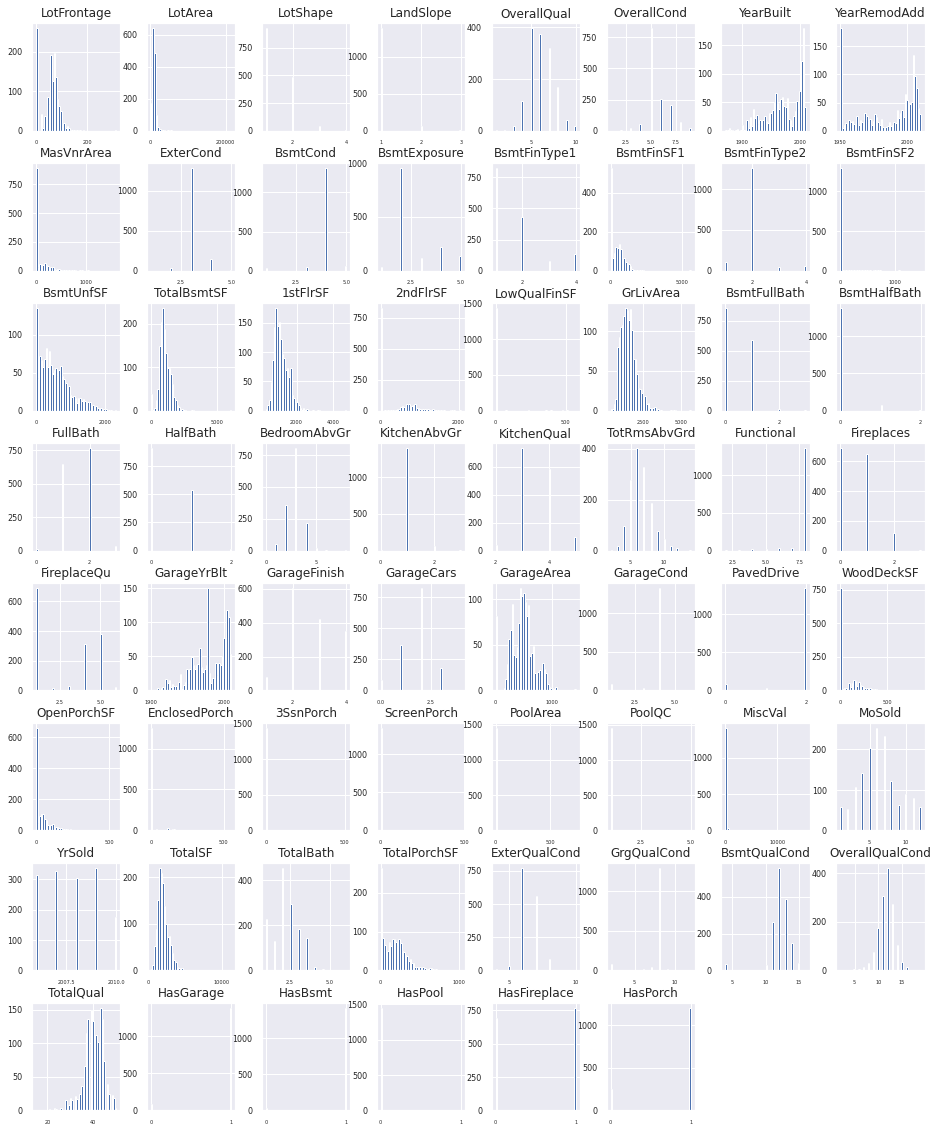

In [ ]:
#Histogram of every numerical feature
train_num.hist(figsize=(16, 20), bins=50, xlabelsize=5, ylabelsize=8);

TotalBsmtSF and 1stFlrSF have very similar distributions. There are several features like TotalBsmtSF, 1stFlrSF, GrLivArea, and GarageArea that have distributions similar to our target, indicating these could possibly be highly correlated with target.

**Examine the Categorical Variables**

In [ ]:
#Grab all categorical features
train_cat = train.select_dtypes(include=['O'])
print('Number of categorical features: {}'.format(len(train_cat.columns)))
train_cat.head()

Number of categorical features: 25


,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,Electrical,GarageType,Fence,MiscFeature,SaleType,SaleCondition
0,60,RL,Pave,None,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,Attchd,None,None,WD,Normal
1,20,RL,Pave,None,Lvl,FR2,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,CBlock,GasA,Y,SBrkr,Attchd,None,None,WD,Normal
2,60,RL,Pave,None,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,Attchd,None,None,WD,Normal
3,70,RL,Pave,None,Lvl,Corner,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,BrkTil,GasA,Y,SBrkr,Detchd,None,None,WD,Abnorml
4,60,RL,Pave,None,Lvl,FR2,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,Attchd,None,None,WD,Normal


In [ ]:
train_cat.describe()

,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,Electrical,GarageType,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,15,5,2,3,4,5,25,9,8,5,8,6,8,15,16,4,6,6,2,6,7,5,5,9,6
top,20,RL,Pave,None,Lvl,Inside,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,PConc,GasA,Y,SBrkr,Attchd,None,None,WD,Normal
freq,536,1151,1454,1369,1311,1052,225,1260,1445,1220,726,1141,1434,515,504,872,647,1428,1365,1334,870,1179,1406,1267,1198


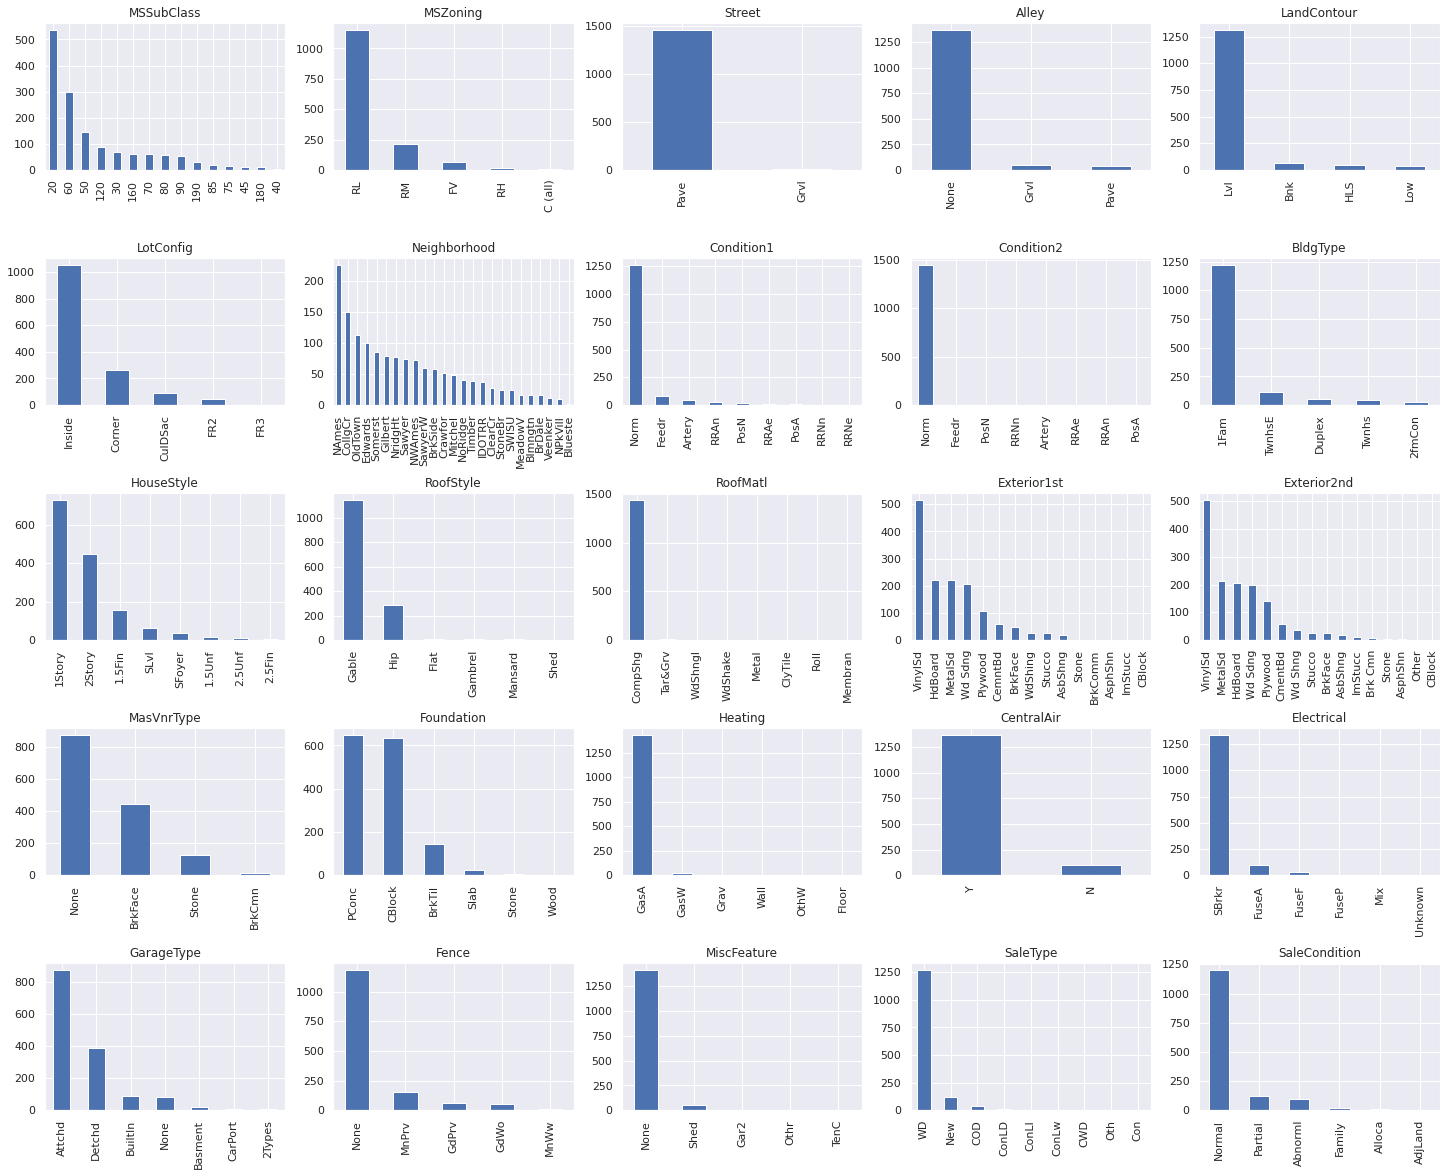

In [ ]:
#Bar Graphs of value counts for each feature
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(25, 20))

i = 0
j = 0
for k in range(len(train_cat.columns)):
  if j == 5:
    i = i + 1
    j = 0
  feature = train_cat[train_cat.columns[k]].value_counts()
  feature.plot.bar(ax=axs[i,j], title=train_cat.columns[k], rot=90);
  j = j + 1

plt.subplots_adjust(wspace=0.2, hspace=0.6)
plt.show()

#**Feature Correlations**

---





We will now examine the correlations of the continuous numerical features to get a sense of whether any features are highly correlated with each other or the target. This information will be useful in the feature selection process, since we can remove a feature that is highly correlated with another and reduce the noise in our dataset. We can also identify the features that have the most influence on the target, which will likely boost the performance of our final model. 

###**Continuous Features**

---






Correlation Matrix

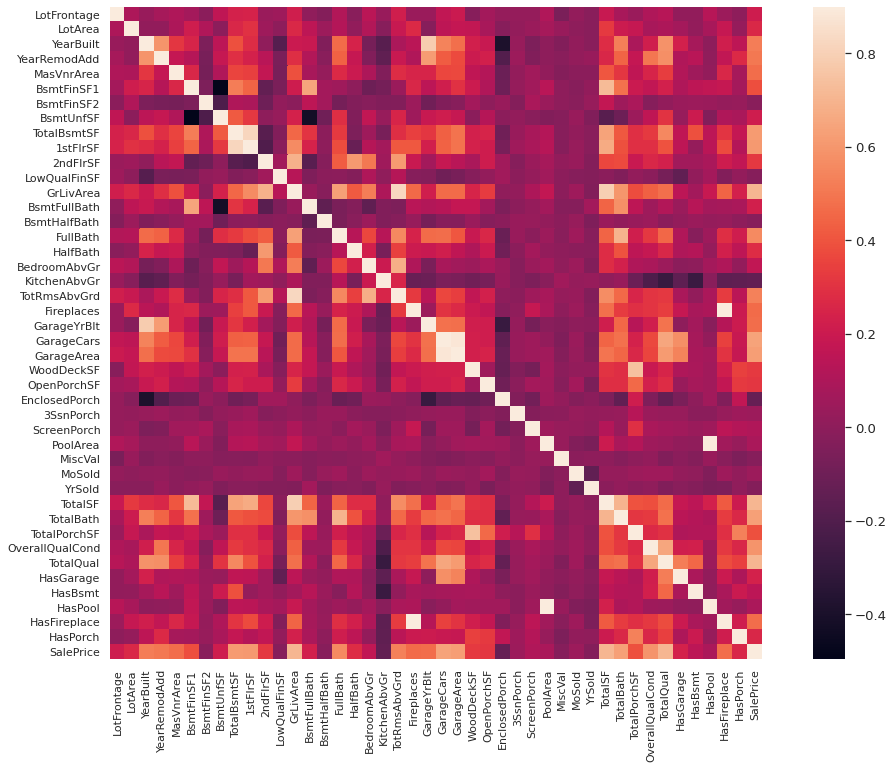

In [ ]:
#Generate correlation matrix heatmap
train_num = pd.concat([train_num,target],axis=1).rename(columns={0:'SalePrice'})
cont_features = train_num.drop(columns=ordinal_features)
corr_matrix = cont_features.corr()
f, ax = plt.subplots(figsize=(18, 12))
sns.set(font_scale=1.2)
full_hm = sns.heatmap(corr_matrix, vmax=.9, square=True);
plt.show()

In [ ]:
#Looking at feature correlations with our target SalePrice
#We look at the absolute value of the correlations because we want to consider negative correlations as well
corr_saleprice = abs(cont_features.corr()).sort_values(by=['SalePrice'], ascending=False)['SalePrice']
corr_saleprice

SalePrice          1.000000
GrLivArea          0.708624
TotalSF            0.708047
TotalQual          0.707021
GarageCars         0.640409
TotalBath          0.631731
GarageArea         0.623431
TotalBsmtSF        0.613581
1stFlrSF           0.605852
OverallQualCond    0.594786
FullBath           0.560664
TotRmsAbvGrd       0.533723
YearBuilt          0.522897
YearRemodAdd       0.507101
MasVnrArea         0.472614
HasFireplace       0.471908
GarageYrBlt        0.471316
Fireplaces         0.466929
TotalPorchSF       0.390993
BsmtFinSF1         0.386420
WoodDeckSF         0.324413
2ndFlrSF           0.319334
OpenPorchSF        0.315856
HalfBath           0.284108
LotArea            0.263843
HasPorch           0.259674
HasGarage          0.236832
BsmtFullBath       0.227122
BsmtUnfSF          0.214479
LotFrontage        0.209624
BedroomAbvGr       0.168213
HasBsmt            0.152829
KitchenAbvGr       0.135907
EnclosedPorch      0.128578
ScreenPorch        0.111447
HasPool            0

In [ ]:
#Looking at the top ten most correlated (besides SalePrice itself)
N = 11 # matrix of N*N
top_N = corr_matrix.nlargest(N, 'SalePrice')['SalePrice']
print(top_N)

SalePrice          1.000000
GrLivArea          0.708624
TotalSF            0.708047
TotalQual          0.707021
GarageCars         0.640409
TotalBath          0.631731
GarageArea         0.623431
TotalBsmtSF        0.613581
1stFlrSF           0.605852
OverallQualCond    0.594786
FullBath           0.560664
Name: SalePrice, dtype: float64


Heatmap of features that have strongest correlation with the target

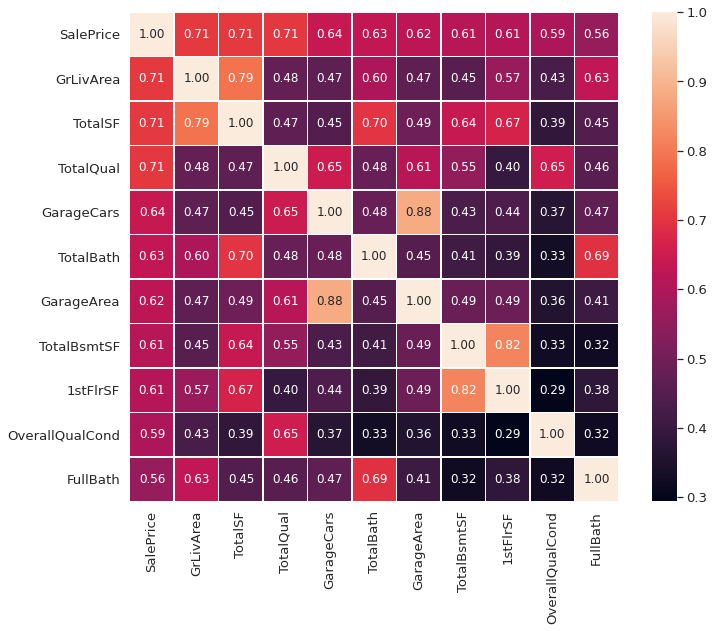

In [ ]:
corr_matrix_value_N = np.corrcoef(cont_features[top_N.index].values.T)
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.2)
zoom_hm = sns.heatmap(corr_matrix_value_N, annot=True, fmt='.2f', annot_kws={'size': 12}, linewidths=0.5, square=True, yticklabels=top_N.index, xticklabels=top_N.index)
plt.show()

• GrLivArea, TotalSF and TotalQual are strongly correlated with "SalePrice"<br>
• "GarageCars" and "GarageArea" are basically the same (the more cars, the more garage area). And as we can see above, they are strongly correlated. Thus, we will need only one of them in our analysis (we will keep "GarageCars")<br>
• "TotalBsmtSF" and "1stFlrSF" are also the same (keep "TotalBsmtSF")<br>


This information gives us an idea of which variables are highly correlated with the target and that will be most important in training our model.


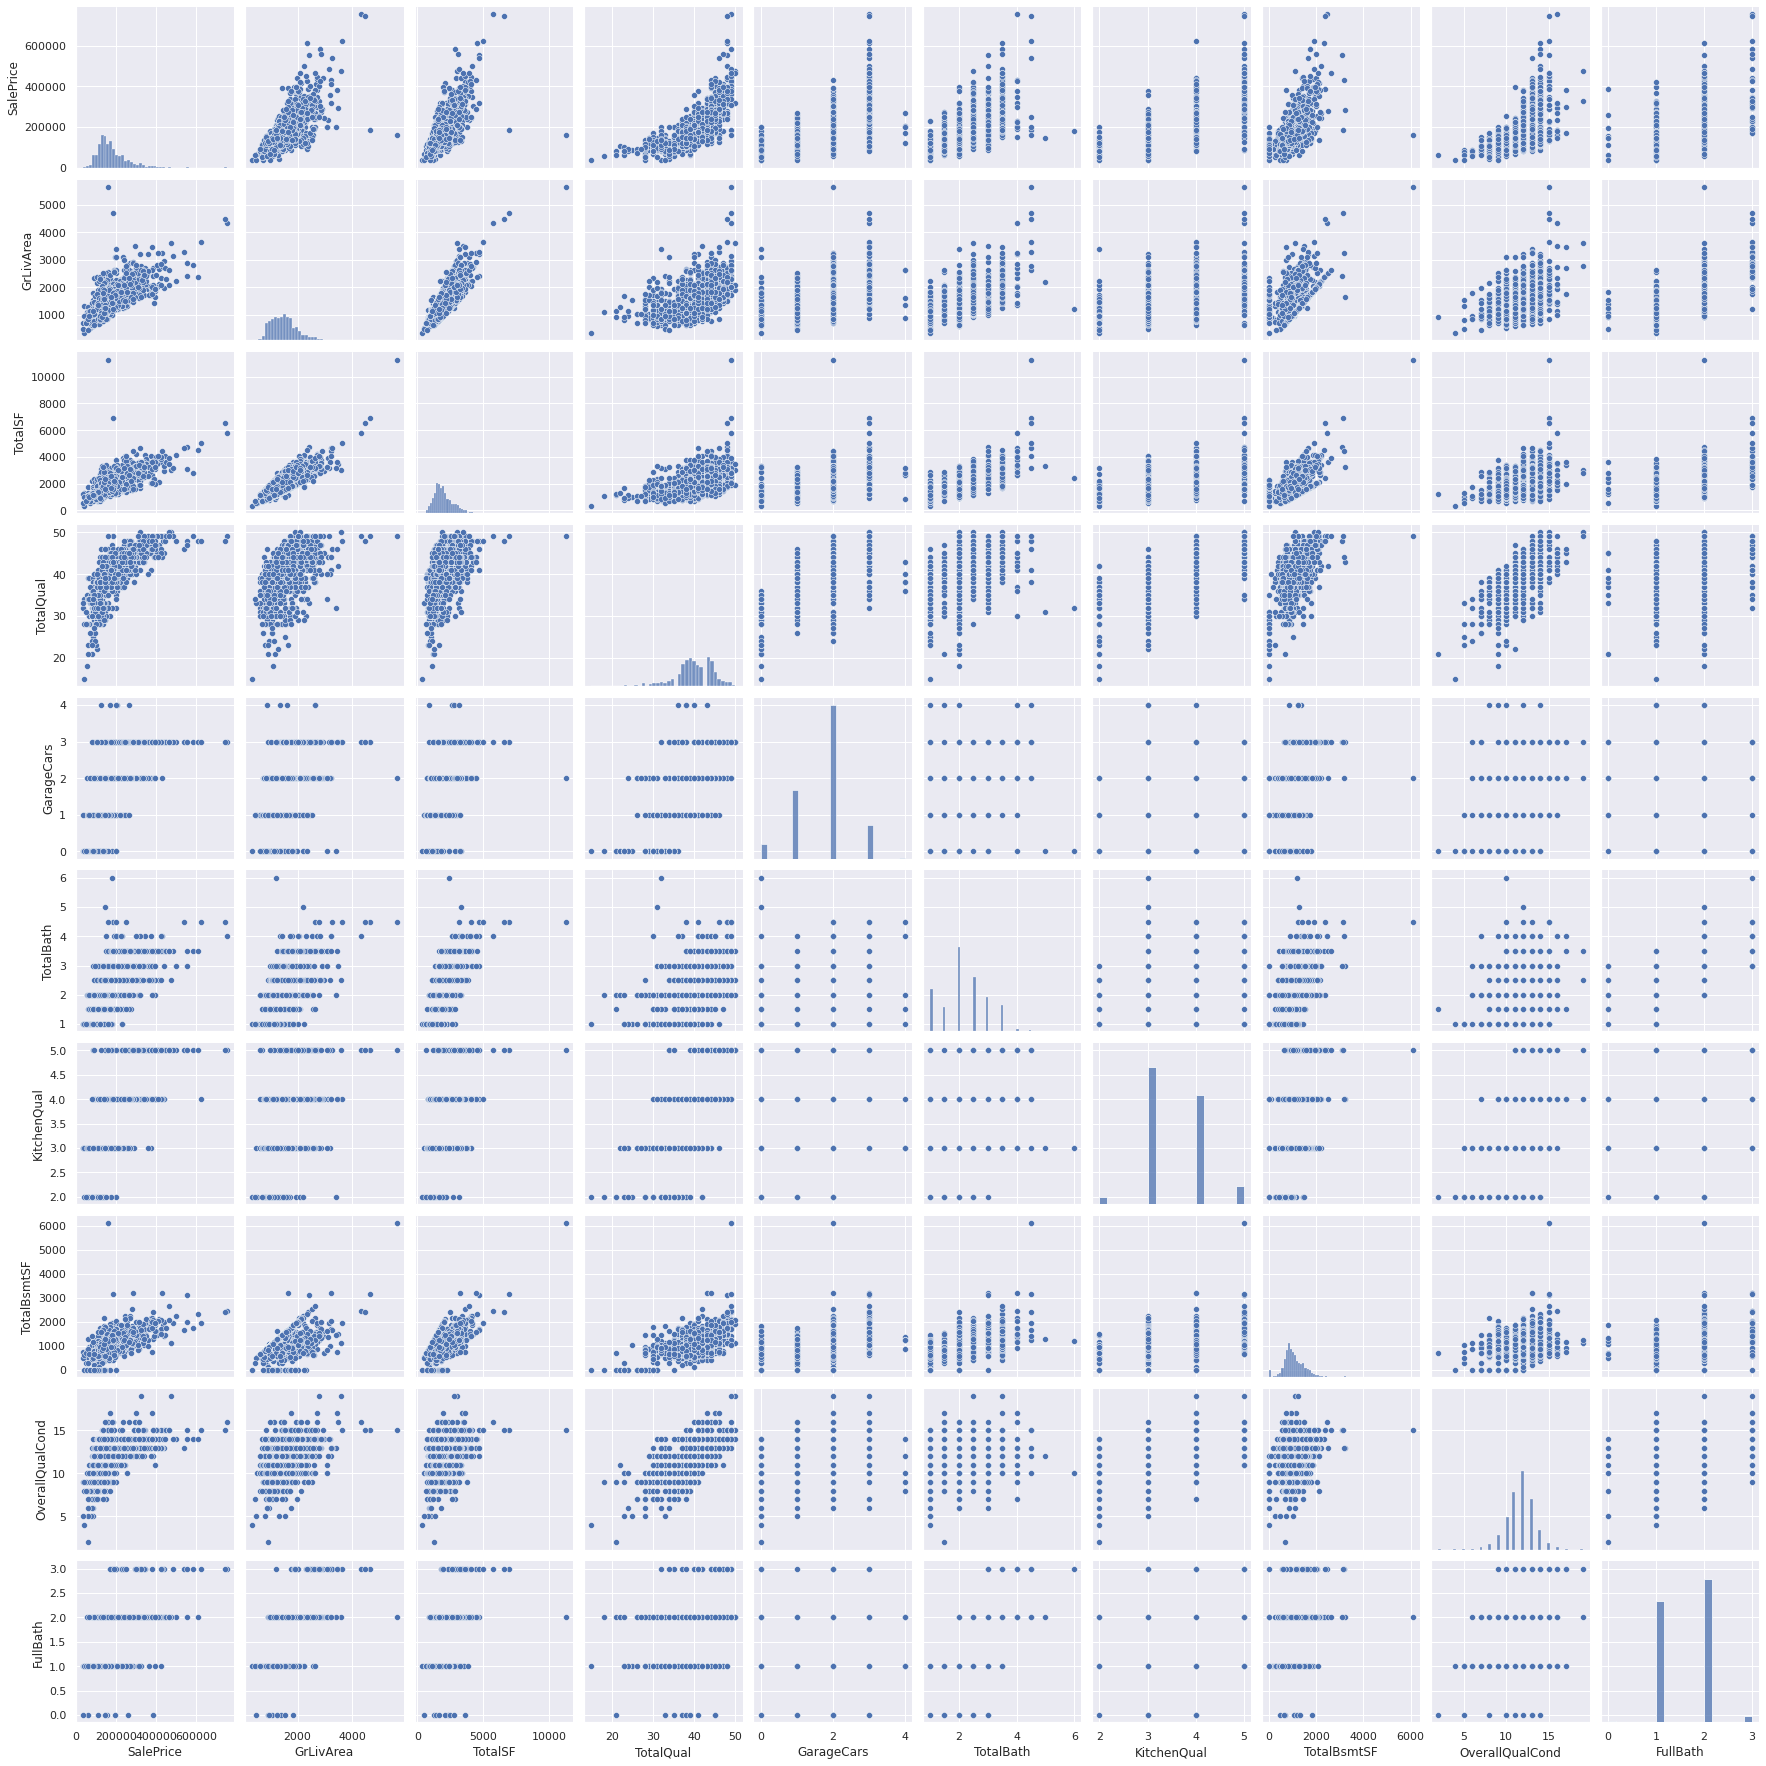

In [ ]:
#We plot the strongest correlation features
sns.set()
sns.pairplot(train_num[['SalePrice', 'GrLivArea','TotalSF','TotalQual','GarageCars','TotalBath','KitchenQual', 'TotalBsmtSF','OverallQualCond', 'FullBath']], size=2.5)
plt.show()

"TotalBsmtSF" and "GrLiveArea" => linear like and most dots are under the line which makes sense because basement area ("TotalBsmtSF") usually are lesser or equal to ground living area ("GrLiveArea")

# **Data Preprocessing**

Encode Categorical Variables


---
We use one-hot-encoding here. In one-hot-encoding, the unique values of each feature are mapped to binary features. So for each unique value for each feature in our dataset, we will have one binary feature in our dataset indicating if that value is present for that example or not. This encoding ensures that categorical variables can be mapped to integers, but that they are not interpreted as ordinal variables.





In [ ]:
train_cat = train.select_dtypes(include=['O'])
ohe = OneHotEncoder(sparse=False)
train_oh = ohe.fit_transform(train_cat)

In [ ]:
feat_names = ohe.get_feature_names(train_cat.columns)
train_oh = pd.DataFrame(train_oh,columns=feat_names)
train_oh.head()

,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,...,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Electrical_Unknown,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Scale Numerical Variables

---
The purpose of scaling our numerical variables is to ensure that our model does not interpret the different magnitudes of our features as signifying the relevance of the features to the target. By scaling all of our numerical features to the same scale, we ensure that whichever model we use initially considers all features equally. 
Here we use sklearn's StandardScaler to scale the numerical features. The StandardScaler standardizes each feature value by subtracting the mean of the feature and dividing by the standard deviation of the feature. 


In [ ]:
train_num = train.select_dtypes(include=['int64','float64']).drop(columns='SalePrice')
ss = StandardScaler()
train_scaled = ss.fit_transform(train_num)
train_scaled = pd.DataFrame(train_scaled,columns=train_num.columns)

Lastly we combine our encoded categorical features and scaled numerical features

In [ ]:
train_processed = pd.concat([train_scaled,train_oh,target],axis=1).sample(frac=1) #shuffle dataset
y_train = train_processed['SalePrice']
X_train = train_processed.drop(columns='SalePrice')

In [ ]:
#Save OneHotEncoder and RobustScaler Instances for encoding and scaling the test set
with open('/content/gdrive/MyDrive/csci567_house-prices-advanced-regression-techniques/one_hot_enc.pkl','wb') as f :
  pickle.dump(ohe,f)
with open('/content/gdrive/MyDrive/csci567_house-prices-advanced-regression-techniques/std_scaler.pkl','wb') as f2 :
  pickle.dump(ss,f2)

In [ ]:
#We will use the log of the target variable since this is what the RMSE will be calculated based on. We use log1p so that 1+x==1 in floating-point accuracy
y_train = np.log1p(y_train)
y_train.shape

(1460,)

In [ ]:
#Final Validation
X_train.shape

(1460, 252)

In [ ]:
#check any missing values
X_train.isnull().any().any()

False

In [ ]:
y_train.isnull().any()

False

# **Feature Selection**

To perform feature selection we will perform Recursive Feature Elimination on our transformed features using a linear regression model. Recursive feature elimination recursively considers smaller and smaller sets of features by eliminating the feature(s) with the lowest importance/weight. This process continues until reaching the desired number of remaining features. To approximate the ideal number of features to select, we will repeat this process for several different numbers of features and compare the performance of a linear regression model using these different numbers of features. We use 5-fold cross validation during training of the linear regression model and use the cross validation score(root mean squared error) to evaluate the performance of the model and its ability to generalize.

In [ ]:
def score_model(estimator,X,y) :
  return cross_validate(estimator,X,y,return_train_score=True,scoring='neg_root_mean_squared_error')

In [ ]:
 #baseline model wihtout any feature selection
lr = LinearRegression()
scores = score_model(lr,X_train,y_train)
avg_train = np.mean(scores['train_score'])
avg_test = np.mean(scores['test_score'])
print(f'Baseline LR Model train score: {avg_train}, test score: {avg_test}')

Baseline LR Model train score: -0.094151135422988, test score: -195627230.79399723


From this we can see that when using all of the 252 features, the baseline model is severely overfitting. 

In [ ]:
def rfe_feat_select(X_train,y_train,estimator,num_feat) :

  rfe = RFE(estimator,num_feat,step=5)
  rfe.fit(X_train,y_train)
  feat_index = rfe.get_support()
  excerpt = X_train.loc[:,feat_index]
  print(f"{len(excerpt.columns)} features selected")
  return excerpt

In [ ]:
feature_sizes = [10,20,50,100,150,200]
best_index = None
best_test_score = -10000000000000
for n in feature_sizes :
  excerpt = rfe_feat_select(X_train,y_train,lr,n)
  lr_select = LinearRegression()
  scores = score_model(lr_select,excerpt,y_train)
  test_score = np.mean(scores['test_score'])
  if  test_score > best_test_score :
    best_feat_train_score = np.mean(scores['train_score'])
    best_test_score = test_score
    best_index = excerpt.columns
print(f'RFE best number of features: {len(best_index)}')
print(f'RFE Selected LR Model best val score: {best_test_score}, corresponding train score: {best_feat_train_score}')
print(f'RFE best features: {best_index}')


10 features selected
20 features selected
50 features selected
100 features selected
150 features selected
200 features selected
RFE best number of features: 50
RFE Selected LR Model best test score: -0.1658706683664622, corresponding train score: -0.15444898764923867
RFE best features: Index(['OverallQual', 'OverallCond', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'TotalSF', 'TotalBath', 'TotalPorchSF',
       'OverallQualCond', 'HasGarage', 'HouseStyle_1.5Fin',
       'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin',
       'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer',
       'HouseStyle_SLvl', 'MasVnrType_BrkCmn', 'MasVnrType_BrkFace',
       'MasVnrType_None', 'MasVnrType_Stone', 'Foundation_BrkTil',
       'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab',
       'Foundation_Stone', 'F

From this we can see that the RFE process significantly improved the test performance of the baseline linear regression model. It also greatly reduced the amount of overfitting. We can also see that many of the features that we saw earlier with high correlation to the target variable were selected by the RFE process, like OverallQual and TotalSF. Many of the features that were selected make intuitive sense as things like the quality and condition of the home and the amount of space are usually among the top things that contribute to the price of a property. 

Finally we can extract our final feature set that will be used in training of our model. Our y_train remains the same.

In [ ]:
X_train = X_train.loc[:,best_index]

# **Proposed Models and Training Methods**

---



During the training process, we plan to use K-Fold Cross Validation again for hyper-parameter tuning. Using a static validation set will reduce the number of training samples and the performance will be dependent on the validation set chosen. K-Fold cross-validation will give us a more robust performance measure.

Due to the limited number of samples in the training set, we will avoid models with very high complexity to reduce the risk of overfitting. Our initial approach will be to iterate and improve on the linear model above.

If the linear model fails to learn the relationships in the dataset, we will consider using a Decision Tree/Random Forest/XGBoost regression model. A tree-based model provides automatic feature selection by ignoring less relevant features, which will be useful for this dataset given the size of the feature space. Additionally, using ensemble learning methods like Random Forest and XGBoost can provide a large performance boost.

Lastly, if the above 2 approaches fail we can consider using a 1-layer neural net to learn nonlinear relationships in the dataset.


The features selected above are our initial starting point for feature selection, and we will continue to iteratively improve on the selected features during training of the model.